# Imports

In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras
from keras.datasets import cifar10, fashion_mnist
from keras.models import load_model
from keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import os
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import UpSampling2D, Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import plot_model

%matplotlib inline

/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


# Architecture Variables

In [2]:
bit_size = 32
num_epochs = 500
batch_size = 500
autoencoder_id='augmented02'
model_path = 'fashion-models/'
log_path = F'fashion-logs/autoencoder-{autoencoder_id}'
tensorboard = TensorBoard(log_dir=log_path)

In [3]:
import yagmail
email = os.environ.get('GMAIL')
pswd = os.environ.get('GMAILPASS')
yag = yagmail.SMTP(email, pswd)

# Load Data

In [4]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [6]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [7]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

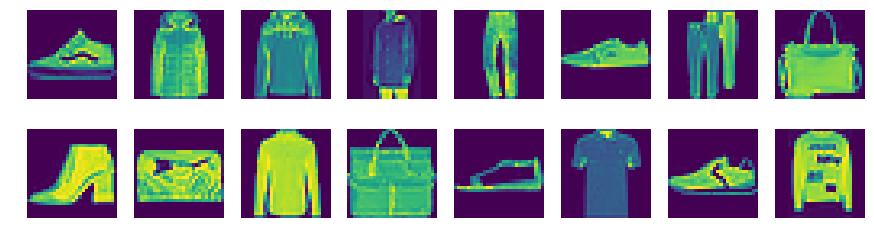

In [8]:

# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
#         ax.set_title(cifar10_classes[y_train[random_index, 0]])

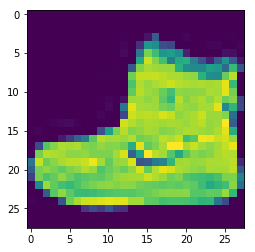

In [9]:
plt.imshow(x_train[0])

In [10]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Architecture

In [11]:
def build_encoder(img_shape, code_size):
    weight_decay = 1e-4
    
    # encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    encoder.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    

    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(Flatten())                  #flatten image to vector
    
    encoder.add(Dense(1024))
    encoder.add((BatchNormalization()))
    encoder.add(Activation('relu'))
    
    encoder.add(Dense(1024))
    encoder.add((BatchNormalization()))
    encoder.add(Activation('relu'))
    
    encoder.add(Dense(code_size))
    
    return encoder


def build_decoder(img_shape, code_size):
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    
#     decoder.add(Dense(1024))
#     decoder.add((BatchNormalization()))
#     decoder.add(Activation('relu'))

    decoder.add(Dense(1024))
    decoder.add(BatchNormalization())
    decoder.add(Activation('relu'))
    
    decoder.add(Dense(1024))
    decoder.add(BatchNormalization())
    decoder.add(Activation('relu'))
    
    decoder.add(Dense(1024))
    decoder.add(BatchNormalization())
    
    decoder.add(Reshape((2,2,256)))
    
    decoder.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    decoder.add(BatchNormalization())
    decoder.add(Activation('relu'))
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    decoder.add(BatchNormalization())
    decoder.add(Activation('relu'))
    
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    decoder.add(BatchNormalization())
    decoder.add(Activation('relu'))
    
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=32, kernel_size=(3, 3)))
    decoder.add(BatchNormalization())
    decoder.add(Activation('relu'))
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
    return decoder

In [12]:
# def build_encoder(img_shape, code_size):
#     weight_decay = 1e-4
    
#     # encoder
#     encoder = Sequential()
#     encoder.add(InputLayer(img_shape))
    
#     encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
# #     encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
# #     encoder.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
# #     encoder.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    

    
# #     encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
#     encoder.add(Flatten())                  #flatten image to vector
    
# #     encoder.add(Dense(1024, activation='relu'))
# #     encoder.add(Dropout(0.1))
# #     encoder.add(Dense(1024, activation='relu'))
    
#     encoder.add(Dense(code_size))
    
#     return encoder


# def build_decoder(img_shape, code_size):
#     decoder = Sequential()
#     decoder.add(InputLayer((code_size,)))
    
# #     decoder.add(Dense(1024, activation='relu'))
    
#     decoder.add(Dense(1024))
    
#     decoder.add(Reshape((2,2,256)))
    
# #     decoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
# #     decoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
# #     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
#     decoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# #     decoder.add(BatchNormalization())
    
# #     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
#     decoder.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
#     return decoder

In [13]:
# def build_deep_autoencoder(img_shape, code_size):
#     H,W,C = img_shape
    
#     # encoder
#     encoder = keras.models.Sequential()
#     encoder.add(L.InputLayer(img_shape))
    
#     encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
# #     encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
# #     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Flatten())                  #flatten image to vector
    
#     encoder.add(L.Dense(2048, activation='elu'))
#     encoder.add(L.Dense(2048, activation='elu'))
# #     encoder.add(L.Dense(1024, activation='elu'))

# #     encoder.add(L.Dropout(rate=0.2))
# #     encoder.add(L.BatchNormalization())
    
# #     encoder.add(L.Dense(512, activation='elu'))
# #     encoder.add(L.Dropout(rate=0.2))
# #     encoder.add(L.BatchNormalization())

# #     encoder.add(L.Dense(256, activation='elu'))
    
# #     encoder.add(L.Dense(128, activation='elu'))
    
#     encoder.add(L.Dense(code_size)) 

#     # decoder
#     decoder = keras.models.Sequential()
#     decoder.add(L.InputLayer((code_size,)))
    
#     decoder.add(L.Dense(4*4*128))  #actual decoder, height*width*3 units
    
# #     decoder.add(L.Dense(128, activation='elu'))
# #     decoder.add(L.Dropout(rate=0.2))
# #     decoder.add(L.BatchNormalization())
    
# #     decoder.add(L.Dense(256, activation='elu'))
# #     decoder.add(L.Dropout(rate=0.2))
# #     decoder.add(L.BatchNormalization())
# #     decoder.add(L.Dense(512, activation='elu'))
    
#     decoder.add(L.Dense(2048, activation='elu'))
#     decoder.add(L.Dense(2048, activation='elu'))
# #     decoder.add(L.Dense(1024, activation='elu'))
    
#     decoder.add(L.Reshape((4,4,128)))
    
#     decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
# #     decoder.add(L.BatchNormalization())
    
#     decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
# #     decoder.add(L.BatchNormalization())
    
#     decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
# #     decoder.add(L.BatchNormalization())
    
# #     decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
#     return encoder, decoder


In [14]:
reset_tf_session()

In [15]:
encoder = build_encoder(IMG_SHAPE, code_size=bit_size)
decoder = build_decoder(IMG_SHAPE, code_size=bit_size)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

In [16]:
def lr_scheduler(epoch):
    lrate = 0.001
    
    if epoch > 15:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0003
    
    return lrate

In [17]:
optimizer = keras.optimizers.adam(decay=1e-6)

In [18]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Training

In [19]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=30,
                             shear_range=0.2,
                             zoom_range=0.2,
                            )

In [20]:
datagen.fit(x_train)

In [21]:
image_generator = datagen.flow(x=x_train, y=x_train, batch_size=batch_size)

In [ ]:
autoencoder.fit_generator(image_generator,
                          steps_per_epoch=len(x_train)/ batch_size,
                          validation_data=[x_test, x_test],
                          epochs=num_epochs,
                          callbacks=[tensorboard]
                         )

Epoch 1/500
120/120 [==============================] - 9s 73ms/step - loss: 0.0492 - val_loss: 0.1040
Epoch 2/500
120/120 [==============================] - 7s 62ms/step - loss: 0.0347 - val_loss: 0.1054
Epoch 3/500
120/120 [==============================] - 7s 62ms/step - loss: 0.0324 - val_loss: 0.0784
Epoch 4/500
120/120 [==============================] - 7s 62ms/step - loss: 0.0311 - val_loss: 0.0491
Epoch 5/500
120/120 [==============================] - 7s 62ms/step - loss: 0.0303 - val_loss: 0.0345
Epoch 6/500
120/120 [==============================] - 8s 63ms/step - loss: 0.0296 - val_loss: 0.0294
Epoch 7/500
120/120 [==============================] - 8s 63ms/step - loss: 0.0292 - val_loss: 0.0319
Epoch 8/500
120/120 [==============================] - 8s 63ms/step - loss: 0.0287 - val_loss: 0.0295
Epoch 9/500
120/120 [==============================] - 8s 63ms/step - loss: 0.0282 - val_loss: 0.0311
Epoch 10/500
120/120 [==============================] - 8s 63ms/step - loss: 0.027

In [ ]:
# autoencoder.fit(x=x_train, y=x_train, epochs=num_epochs, batch_size=batch_size, shuffle=True,
#                 validation_data=[x_test, x_test],
#                 callbacks=[tensorboard],
#                 verbose=1,
#                 initial_epoch= 0)

In [ ]:
yag.send('mizutaninikkou@gmail.com', subject = "Training Done", contents='Training Done')

In [ ]:
autoencoder.save(F'{model_path}autoencoder{autoencoder_id}.h5')
encoder.save(F'{model_path}encoder{autoencoder_id}.h5')
decoder.save(F'{model_path}decoder{autoencoder_id}.h5')

In [ ]:
autoencoder = load_model(F'{model_path}autoencoder{autoencoder_id}.h5')
encoder = load_model(F'{model_path}encoder{autoencoder_id}.h5')
decoder = load_model(F'{model_path}decoder{autoencoder_id}.h5')

In [ ]:
code = encoder.predict(x_test[0][None])

In [ ]:
reco = decoder.predict(code)[0].reshape(28,28)

In [ ]:
plt.imshow(reco)

In [ ]:
plt.imshow(x_test[0].reshape(28,28))